# Convolutional Neural Networks - Build Model
---
In this notebook, we build and train a **CNN** to classify images from the CIFAR-10 database. 
* The code provided here are **almost** working. You are required to build up a CNN model and train it.
* Make sure you covered implementations of the **TODO**s in this notebook

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='cifar_data.png' width=50% height=50% />

### Optional: Use [CUDA](http://pytorch.org/docs/stable/cuda.html) if Available

Since these are color (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, but they utilize GPU's for effcient parallel computation.

In [1]:
import torch
print("torch version:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("mps available:", torch.backends.mps.is_available())


torch version: 2.10.0
cuda available: False
mps available: True


In [2]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [3]:
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

transform = T.Compose([T.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

images, labels = next(iter(trainloader))
print(images.shape, labels.shape)


100.0%
/Users/anjalikale/Downloads/build_cnn/.venv/lib/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


torch.Size([64, 3, 32, 32]) torch.Size([64])


## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)
---
Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

### Visualize a Batch of Training Data

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Matplotlib is building the font cache; this may take a moment.


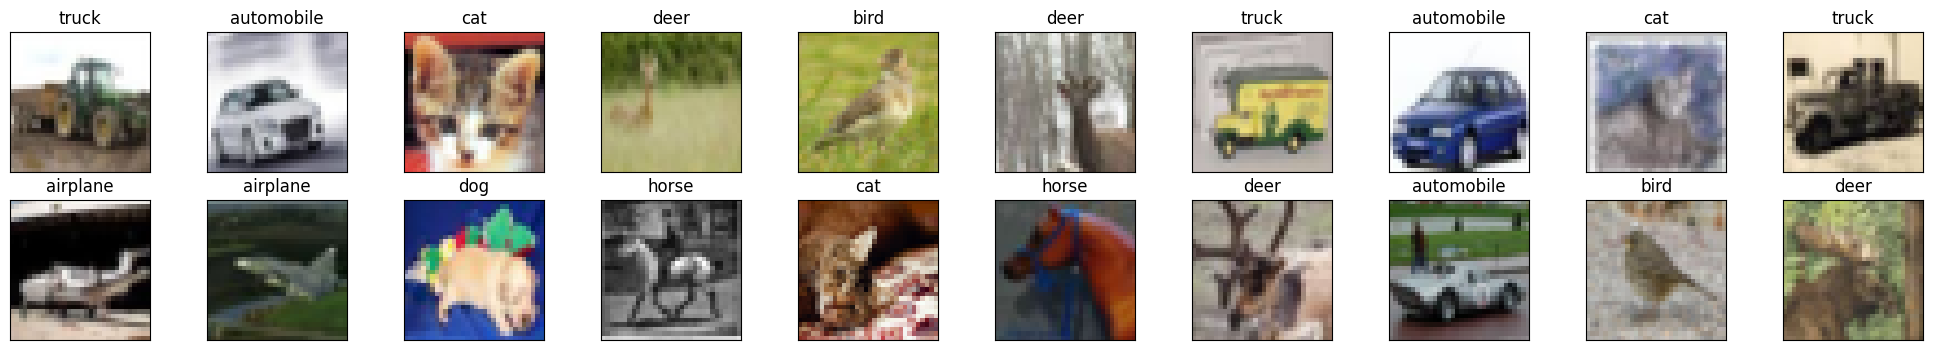

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
#images, labels = dataiter.next() #python, torchvision version match issue
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

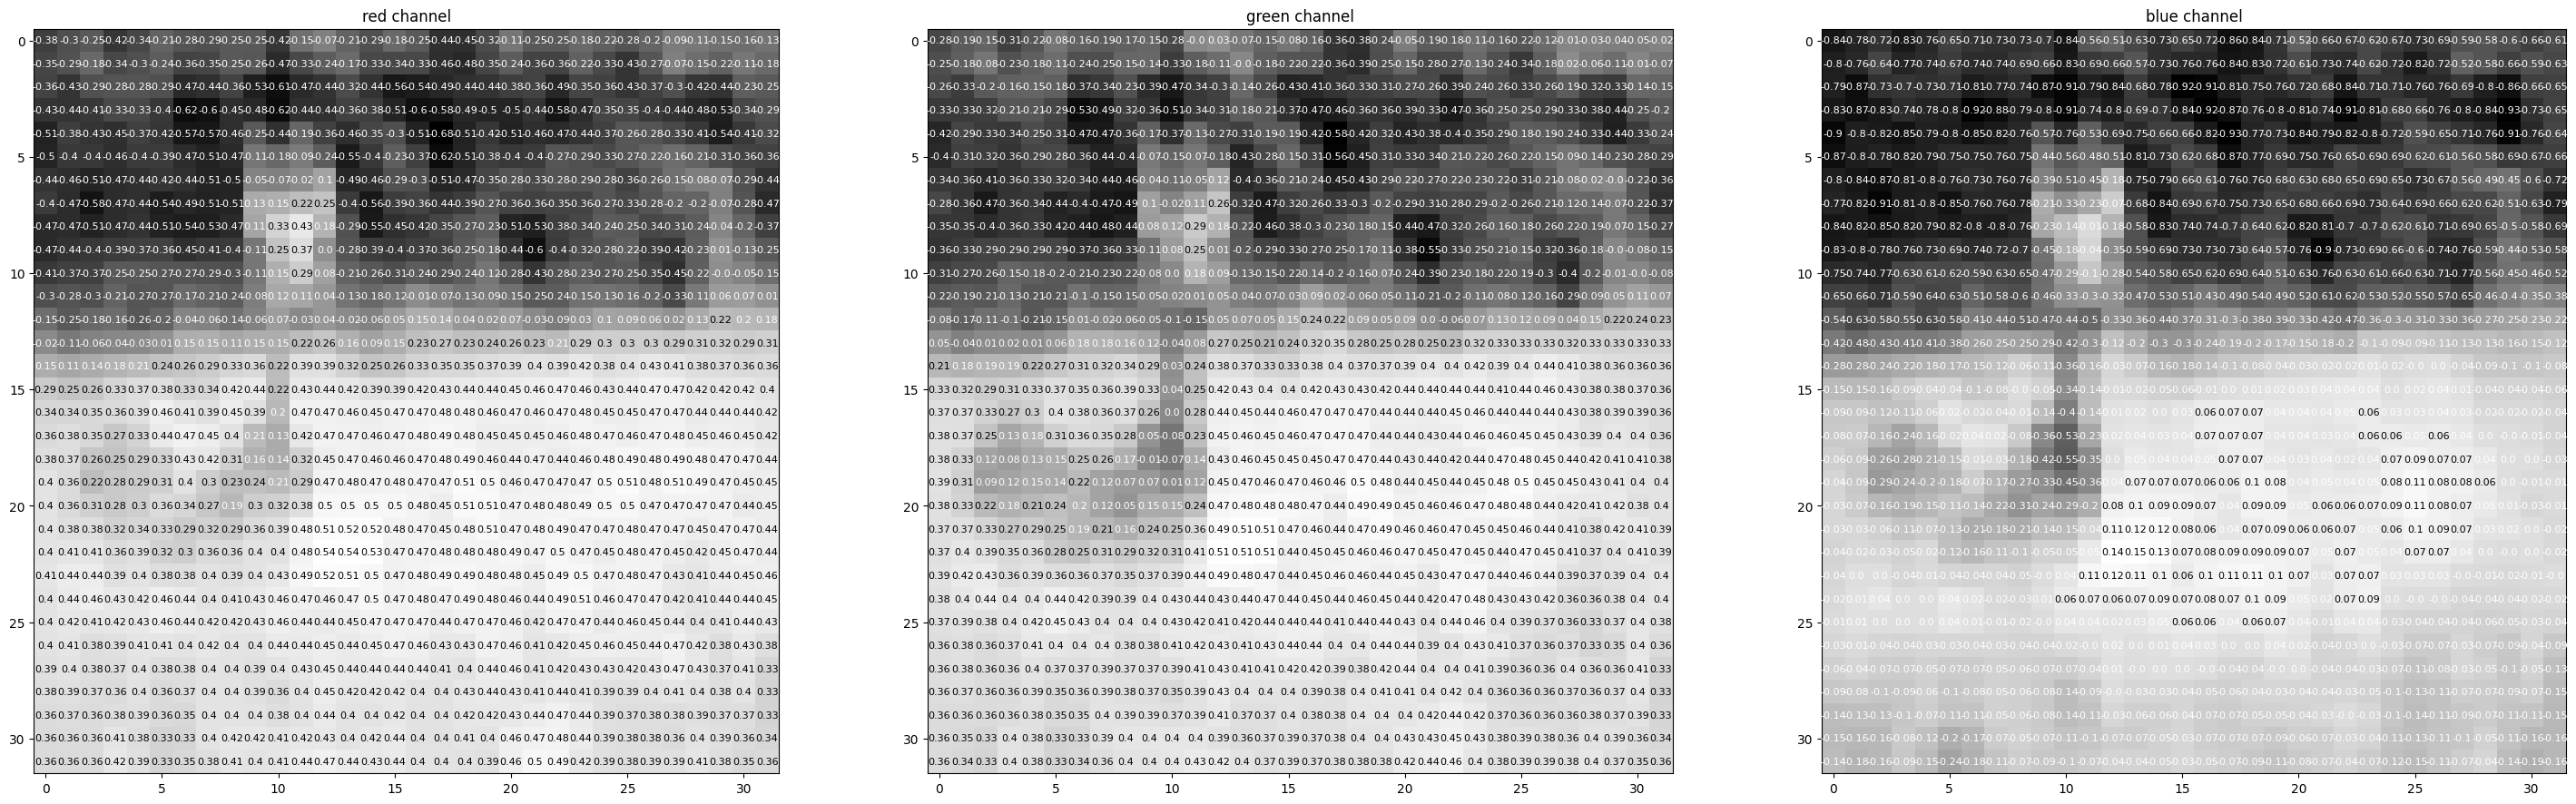

In [7]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## **TODO**: Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)
---
Build up your own Convolutional Neural Network using Pytorch API:
- nn.Conv2d(): for convolution
- nn.MaxPool2d(): for maxpooling (spatial resolution reduction)
- nn.Linear(): for last 1 or 2 layers of fully connected layer before the output layer.
- nn.Dropout(): optional, [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) can be used to avoid overfitting.
- F.relu(): Use ReLU as the activation function for all the hidden layers

The following is a skeleton example that's not completely working. 

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # TOTO: Build multiple convolutional layers (sees 32x32x3 image tensor in the first hidden layer)
        # for example, conv1, conv2 and conv3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)   # 32x32 -> 32x32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # 16x16 -> 16x16 (after pool)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # 8x8 -> 8x8 (after pool)

        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # : Build some linear layers (fully connected)
        # for example, fc1 and fc2
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)  # CIFAR-10 has 10 classes

        # pout layer (p=0.25, you can adjust)
        # example self.dropout = nn.Dropout(0.25)
        self.dropout = nn.Dropout(0.25)
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        # assume we have 2 convolutional layers defined agove
        # and we do a maxpooling after each conv layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))     # (batch, 128, 8, 8)
        x = torch.flatten(x, 1) 
        # flatten x at this point to get it ready to feed into the fully connected layer(s)
        # Can use this but need to figure out the actual value for a, b and c
        # x = x.view(-1, a * b * c)

        # optional add dropout layer
        #x = self.dropout(x)
        
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # optional add dropout layer
        #x = self.dropout(x)
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
print("Using device:", device)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
Using device: mps


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)
---
Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

The following is working code, but you can make your own adjustments.

**TODO**: try to compare with ADAM optimizer

In [9]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


## Train the Network
---
Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

In [19]:
# number of epochs to train the model, you decide the number
n_epochs = 5

valid_loss_min = np.inf # track change in validation loss
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
print("Using device:", device)

train_losses = []
valid_losses = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)

    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_trained.pt')
        valid_loss_min = np.inf



Using device: mps
Epoch: 1 	Training Loss: 0.455599 	Validation Loss: 1.685112
Validation loss decreased (inf --> 1.685112).  Saving model ...
Epoch: 2 	Training Loss: 0.382623 	Validation Loss: 1.660359
Validation loss decreased (inf --> 1.660359).  Saving model ...
Epoch: 3 	Training Loss: 0.323264 	Validation Loss: 1.807218
Validation loss decreased (inf --> 1.807218).  Saving model ...
Epoch: 4 	Training Loss: 0.290734 	Validation Loss: 1.938053
Validation loss decreased (inf --> 1.938053).  Saving model ...
Epoch: 5 	Training Loss: 0.248210 	Validation Loss: 1.936789
Validation loss decreased (inf --> 1.936789).  Saving model ...


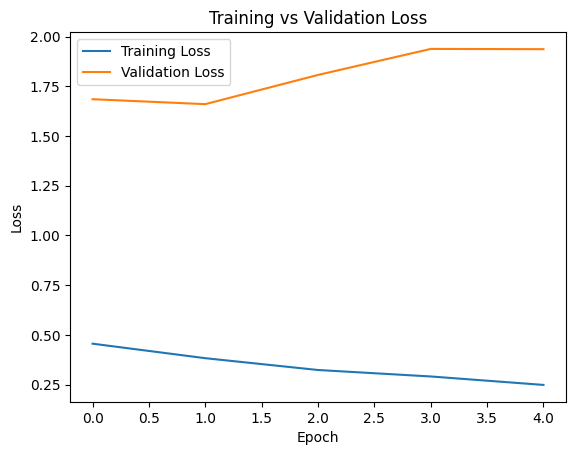

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


###  Load the Model with the Lowest Validation Loss
This is the model we will use for testing, which is the model we saved in the last step

In [15]:
model.load_state_dict(torch.load('model_trained.pt'))

<All keys matched successfully>

## Test the Trained Network
---
Test your trained model on previously unseen data! Remember we have downloaded `train_data` and `test_data`. We will use `test_data` through `test_loader`.

A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

In [16]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.detach().cpu().numpy())

    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.752718

Test Accuracy of airplane: 78% (784/1000)
Test Accuracy of automobile: 84% (841/1000)
Test Accuracy of  bird: 60% (607/1000)
Test Accuracy of   cat: 56% (568/1000)
Test Accuracy of  deer: 72% (729/1000)
Test Accuracy of   dog: 57% (579/1000)
Test Accuracy of  frog: 84% (847/1000)
Test Accuracy of horse: 80% (800/1000)
Test Accuracy of  ship: 81% (817/1000)
Test Accuracy of truck: 87% (879/1000)

Test Accuracy (Overall): 74% (7451/10000)


In [21]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


## Task 2A: Feature maps from first conv layer


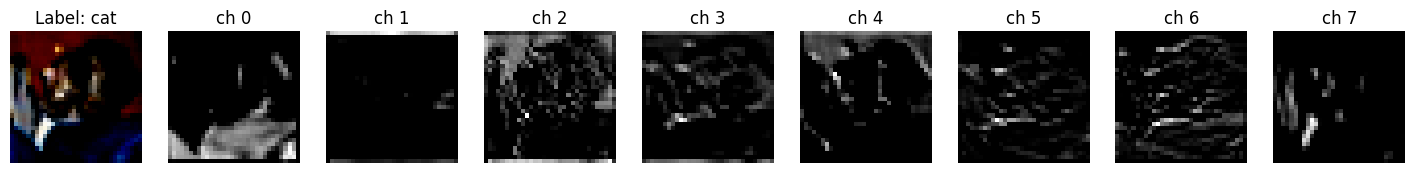

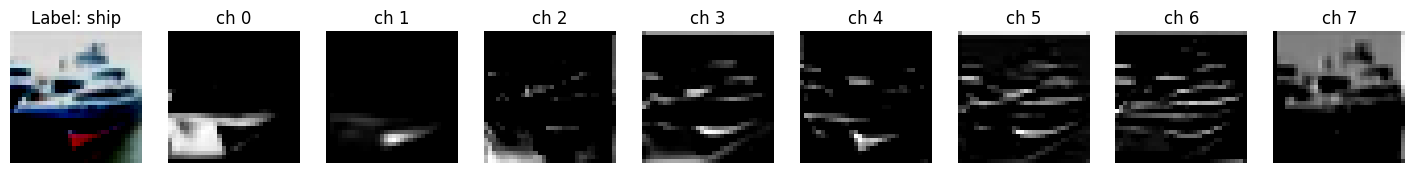

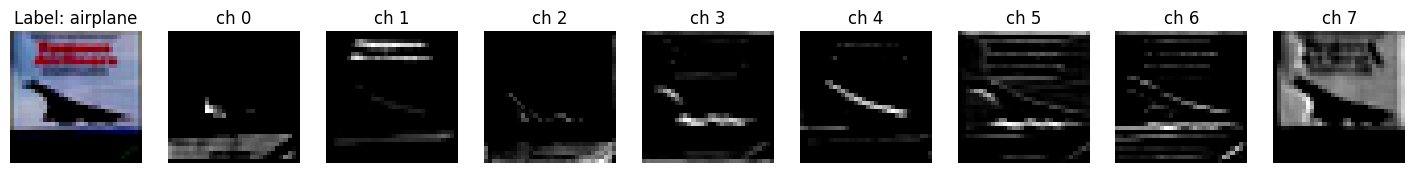

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

model.eval()

# pick 3 test images from different classes
picked = []
picked_labels = set()
i = 0

while len(picked) < 3:
    img, label = test_data[i]   # test_data must already exist
    if label not in picked_labels:
        picked.append((img, label))
        picked_labels.add(label)
    i += 1

# show feature maps from conv1
for img, label in picked:
    x = img.unsqueeze(0).to(device)   # [1,3,32,32]
    
    with torch.no_grad():
        fmap = F.relu(model.conv1(x))   # [1, C, H, W]
    
    fmap = fmap.cpu()

    # plot original + 8 feature maps
    fig, axes = plt.subplots(1, 9, figsize=(18, 3))

    # original image
    orig = img.permute(1, 2, 0).cpu()
    orig = orig.clamp(0, 1)  # avoid imshow clipping warning
    axes[0].imshow(orig)
    axes[0].set_title(f"Label: {classes[label]}")
    axes[0].axis("off")

    # 8 feature maps
    for k in range(8):
        axes[k+1].imshow(fmap[0, k], cmap="gray")
        axes[k+1].set_title(f"ch {k}")
        axes[k+1].axis("off")

    plt.show()


##Task 2B 

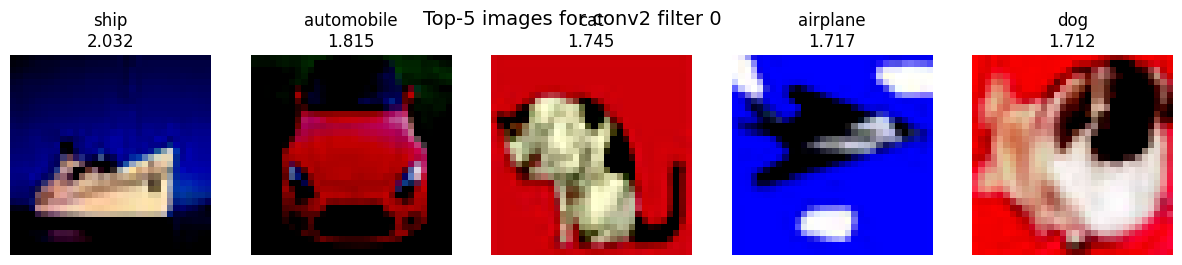

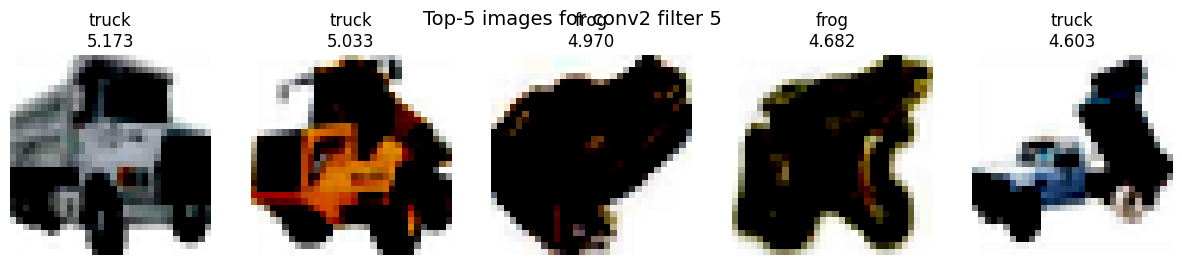

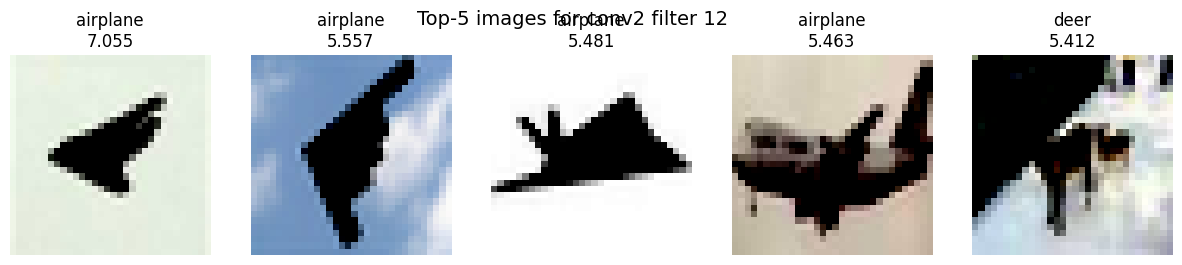

In [30]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()

filters = [0, 5, 12]
topk = {f: [] for f in filters}

for i in range(len(test_data)):
    img, label = test_data[i]
    x = img.unsqueeze(0).to(device)

    with torch.no_grad():
        x1 = F.relu(model.conv1(x))     # [1, 32, 32, 32]
        x1 = model.pool(x1)             # [1, 32, 16, 16]  (only if your model pools here)
        fmap = F.relu(model.conv2(x1))  # [1, 64, 16, 16]

    fmap = fmap.cpu()

    for f in filters:
        score = fmap[0, f].max().item()
        topk[f].append((score, img, label, i))
        topk[f] = sorted(topk[f], key=lambda t: t[0], reverse=True)[:5]

# Plot top-5 images for each filter
for f in filters:
    plt.figure(figsize=(15, 3))
    for j, (score, img, label, idx) in enumerate(topk[f]):
        plt.subplot(1, 5, j+1)
        pic = img.detach().cpu().permute(1,2,0).clamp(0,1)
        plt.imshow(pic)
        plt.title(f"{classes[label]}\n{score:.3f}")
        plt.axis("off")
    plt.suptitle(f"Top-5 images for conv2 filter {f}", fontsize=14)
    plt.show()


### Visualize Sample Test Results

The following is working code, but you are encouraged to make your own adjustments and enhance the visualization.

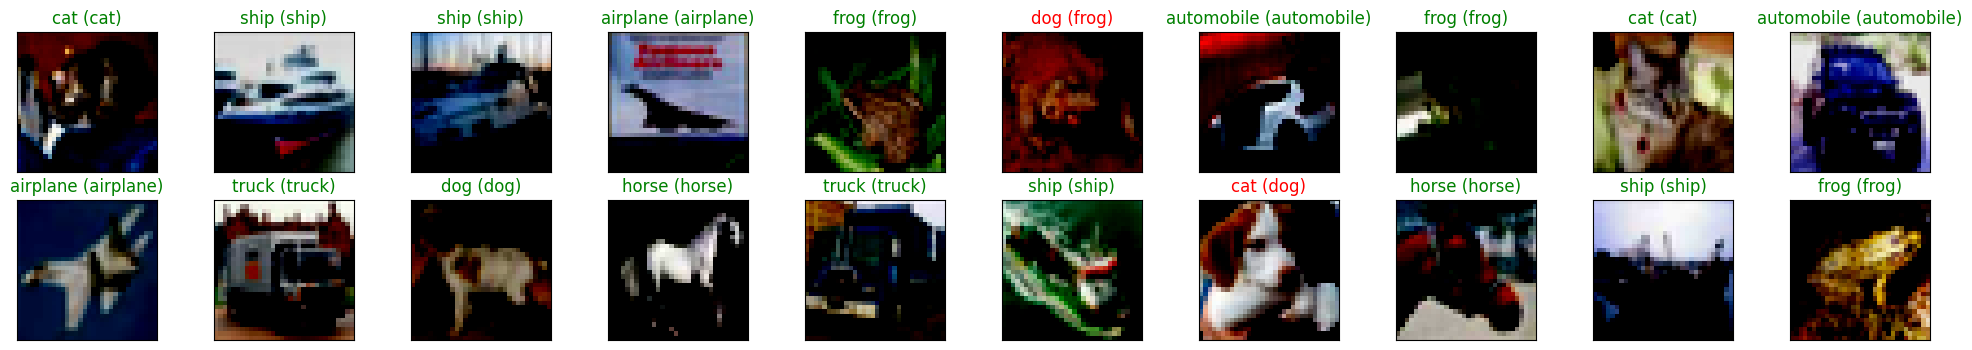

In [26]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
images = images.to(device)
labels = labels.to(device)


# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.detach().cpu().numpy())


# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    img = images[idx].detach().cpu()
    img = img.permute(1, 2, 0)          # CHW -> HWC
    img = img.clamp(0, 1)               # fix for normalized images
    ax.imshow(img)


    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx].item()]),
             color="green" if preds[idx] == labels[idx].item() else "red")
